This file is to test my model on the TUH-EEG-seizure data

Not DMD


In [1]:
RUN_PYTHON_SCRIPT = False
MODEL_NAME = "Lay2_dis_1step_epoch3"

'Lay2_dis_1step_epoch3'

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
import time

if not RUN_PYTHON_SCRIPT:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
import importlib
import data_utils.eeg_load
importlib.reload(data_utils.eeg_load)

<module 'data_utils.eeg_load' from '/data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/data_utils/eeg_load.py'>

In [5]:
#from models.main_model import myNet
from models.model_utils import generate_position_encode
from data_utils.eeg_load import EEG_data, MyDataLoader, digitize_data, rec_data
from utils.misc import delta_time, load_pkl_folder2dict, save_pkl_dict2folder, truncated_mean_upper

In [6]:
# pkgs for pytorch (on Apr 3, 2023)
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    #torch.cuda.set_device(3)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda")
else:
    torch.set_default_tensor_type(torch.DoubleTensor)
    device = torch.device("cpu")

# Load data and model

In [7]:
model_res = load_pkl_folder2dict(RES_ROOT/f"{MODEL_NAME}", excluding=["opt*"]);

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../results/Lay2_dis_1step_epoch3/config.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../results/Lay2_dis_1step_epoch3/loss_fn.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../results/Lay2_dis_1step_epoch3/losses.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../results/Lay2_dis_1step_epoch3/losses_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../results/Lay2_dis_1step_epoch3/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../results/Lay2_dis_1step_epoch3/paras_train.pkl


In [9]:
model_res.config

{'nfeature': 19,
 'ndim': 256,
 'dropout': 0,
 'n_layer': 2,
 'n_head': 8,
 'is_mask': True,
 'is_bias': True,
 'block_size': 256,
 'batch_size': 2,
 'move_step': 32,
 'fs': 90,
 'target_dim': 361,
 'k': 8}

# Inference

In [125]:
from sklearn.metrics import confusion_matrix

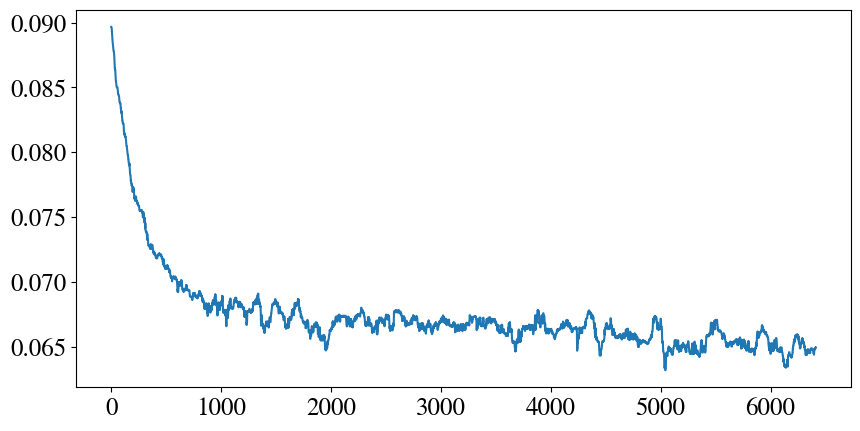

In [126]:
def moving_median(data, window_size):
    if window_size < 1 or not isinstance(window_size, int):
        raise ValueError("Window size must be a positive integer")

    if len(data) < window_size:
        raise ValueError("Window size must be smaller than or equal to the length of the data")

    result = []
    for i in range(len(data) - window_size + 1):
        result.append(np.median(data[i:i + window_size]))
    return result
plt.plot(moving_median(model_res.losses_test[:], 100))
#plt.yscale("log")

In [127]:
config = model_res.config
trained_model = model_res.model;
pos_enc = generate_position_encode(config.block_size, config.nfeature).unsqueeze(0);

In [128]:
def raw2input(X, pos_enc):
    X_input = X + pos_enc
    X_raw = X
    return X_input, X_raw

def _raw_pred_dis(X):
    X_inp, X_raw = raw2input(X, pos_enc)
    trained_model.eval()
    with torch.no_grad():
        Y_pred_prbs = trained_model(X_inp, X_raw)
    Y_pred_dis = Y_pred_prbs.argmax(axis=-1)
    Y_pred = rec_data(Y_pred_dis.cpu().numpy(), config.k)
    Y_pred = torch.tensor(Y_pred)
    return Y_pred

In [129]:
def pred_steps(X_init, raw_pred, num_step):
    """To make num_step prediction based on X_init 
        args:
            X_init: batchsize x blocksize x numseq, tensor
            raw_pred: A fn to make prediction for 1 step
            num_step: num of steps
    """
    X_ext = X = X_init 
    for k in range(num_step):
        Y_pred = raw_pred(X);
        X_ext = torch.cat([X_ext, Y_pred[:, -1:, :]], axis=1)
        X = X_ext[:, -config.block_size:]
    Y_pred_mul = X_ext[:, -num_step:];
    return Y_pred_mul

## predict 1 step

In [38]:
train_data = EEG_data("train_train", "AR", 
                      move_dict=dict(winsize=config.block_size+1,
                                     stepsize=config.block_size+1,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False)
                     )
test_data = EEG_data("train_test", "AR", 
                      move_dict=dict(winsize=config.block_size+1, 
                                     stepsize=config.block_size+1, 
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False)
                    )

train_data_loader = MyDataLoader(train_data, batch_size=1, shuffle=False)
test_data_loader = MyDataLoader(test_data, batch_size=4, shuffle=False)
print(len(train_data_loader), len(test_data_loader))

651172 13890


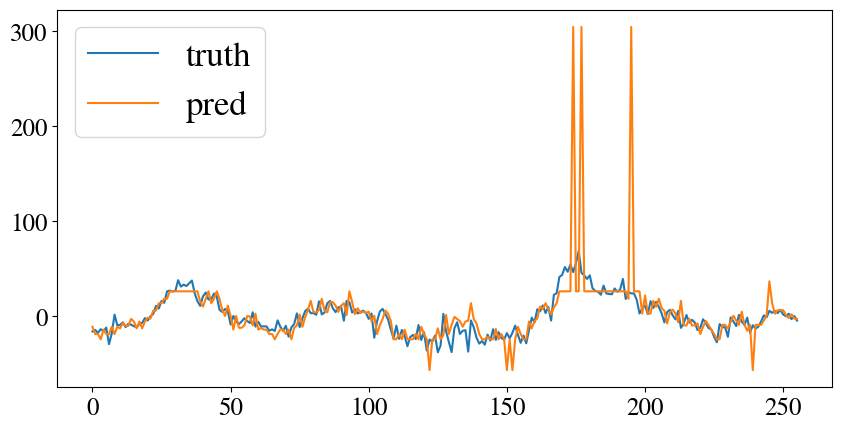

In [39]:

ix = 0
batch = test_data_loader(ix)
#batch = train_data_loader(ix)
batch = batch * 1e6
X, Y_true = batch[:, :-1], batch[:, 1:]

Y_pred = _raw_pred_dis(X)
sub_idx = 0
seq_idx = 0
plt.plot(Y_true[sub_idx, :, seq_idx], label="truth")
plt.plot(Y_pred[sub_idx, :, seq_idx], label="pred")
plt.legend()

## Predict multiple steps

In [26]:
start_t = 2000
full_seq = torch.tensor(test_data["sub8"])*1e6;
full_seq = full_seq[start_t:]
full_seq = full_seq.unsqueeze(0);
X_init = full_seq[:, :config.block_size];

num_step = 100
Y_pred_mul = pred_steps(X_init, _raw_pred_dis, num_step);

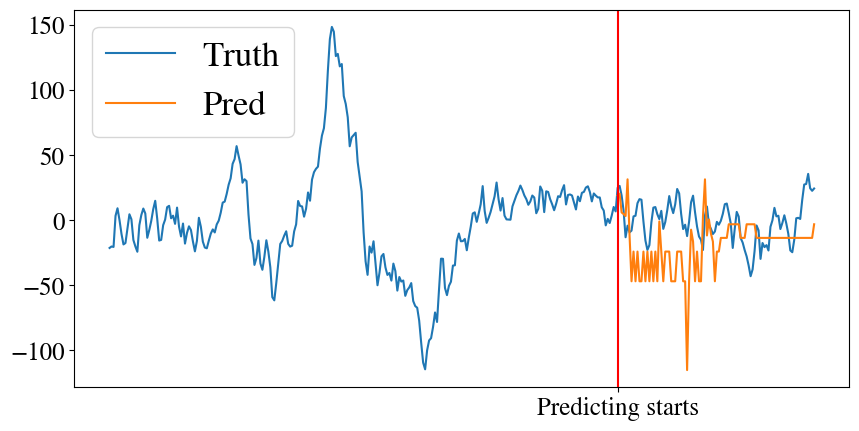

In [27]:

batch_idx = 0
seq_idx = 1
Y_pred_mul_sel = Y_pred_mul[batch_idx]
Y_true_mul_full_sel = full_seq[batch_idx, :(len(Y_pred_mul_sel)+config.block_size)]

plt.plot(Y_true_mul_full_sel[:, seq_idx], label="Truth")
plt.plot(np.arange(config.block_size, len(Y_true_mul_full_sel)), Y_pred_mul_sel[:, seq_idx], label="Pred")
plt.axvline(x=config.block_size, color="red")
plt.xticks([config.block_size], ["Predicting starts"])
plt.legend(loc="upper left")

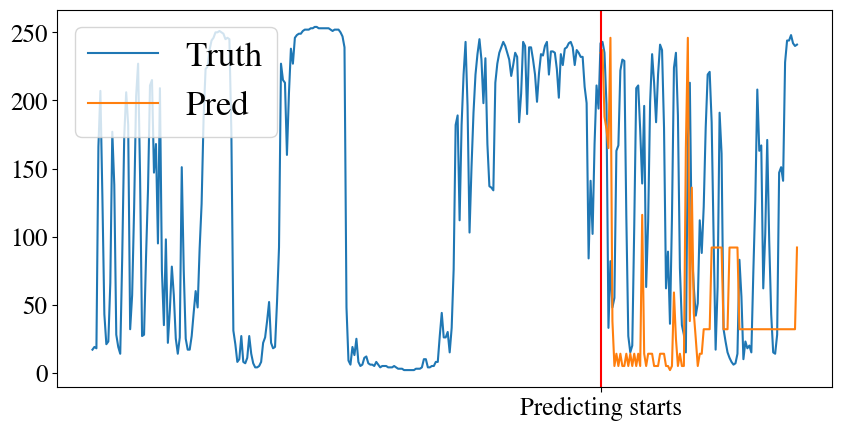

In [28]:
Y_pred_mul_sel_dis = digitize_data(Y_pred_mul_sel, config.k)
Y_true_mul_full_sel_dis = digitize_data(Y_true_mul_full_sel, config.k)

plt.plot(Y_true_mul_full_sel_dis[:, seq_idx], label="Truth")
plt.plot(np.arange(config.block_size, len(Y_true_mul_full_sel_dis)), Y_pred_mul_sel_dis[:, seq_idx], label="Pred")
plt.axvline(x=config.block_size, color="red")
plt.xticks([config.block_size], ["Predicting starts"])
plt.legend(loc="upper left")

<AxesSubplot:>

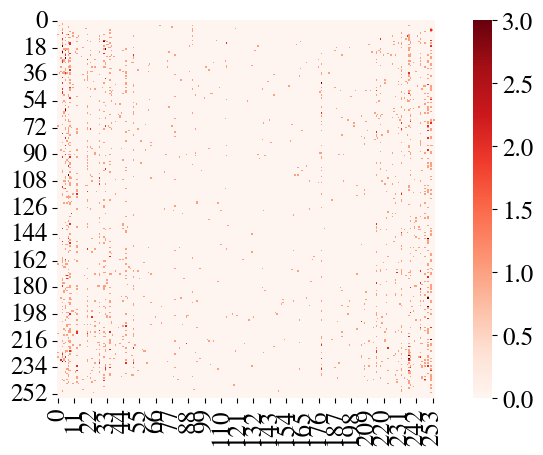

In [29]:
vec_true = Y_true_mul_full_sel_dis[config.block_size:].flatten();
vec_pred = Y_pred_mul_sel_dis.flatten();
conf_mat = confusion_matrix(vec_true, vec_pred);
sns.heatmap(conf_mat, square=True,  cmap="Reds")

## evaluate

In [130]:
from collections import defaultdict as ddict

In [131]:
num_step_uplimit = 200 
train_data = EEG_data("train_train", "AR", 
                      move_dict=dict(winsize=config.block_size+num_step_uplimit,
                                     stepsize=config.block_size+num_step_uplimit,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False)
                     )
test_data = EEG_data("train_test", "AR", 
                      move_dict=dict(winsize=config.block_size+num_step_uplimit, 
                                     stepsize=config.block_size+num_step_uplimit, 
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False)
                    )

train_data_loader = MyDataLoader(train_data, batch_size=4, shuffle=False)
test_data_loader = MyDataLoader(test_data, batch_size=4, shuffle=False)

In [132]:
for num_step in [1, 2, 4, 8, 16, 32, 64, 128]:
    save_path = MIDRES_ROOT/f"{MODEL_NAME}_{num_step}step_pred_labs"
    if save_path.exists():
        save_res = load_pkl_folder2dict(save_path)
    else:
        save_res = ddict(list)
    
    all_true_dis = []
    all_pred_dis = []
    sel_idxs = np.random.choice(len(test_data_loader), size=int(200/num_step), replace=False)
    #sel_idxs = np.arange(int(200/num_step))
    for ix in tqdm(sel_idxs, desc=f"{num_step} step"):
    
        batch = test_data_loader(ix) * 1e6;
        X_init = batch[:, :config.block_size];
        Y_true_mul = batch[:, config.block_size:(config.block_size+num_step)]
        Y_pred_mul = pred_steps(X_init, _raw_pred_dis, num_step)
        
        Y_true_mul_dis = digitize_data(Y_true_mul.cpu().numpy(), config.k);
        Y_pred_mul_dis = digitize_data(Y_pred_mul.cpu().numpy(), config.k);
        all_true_dis.append(Y_true_mul_dis.flatten())
        all_pred_dis.append(Y_pred_mul_dis.flatten());
        
    all_true_dis = np.concatenate(all_true_dis)
    all_pred_dis = np.concatenate(all_pred_dis);
    
    save_res["all_trues_dis"].append(all_true_dis)
    save_res["all_preds_dis"].append(all_pred_dis)
    save_pkl_dict2folder(save_path, save_res, is_force=True, verbose=False)

128 step: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


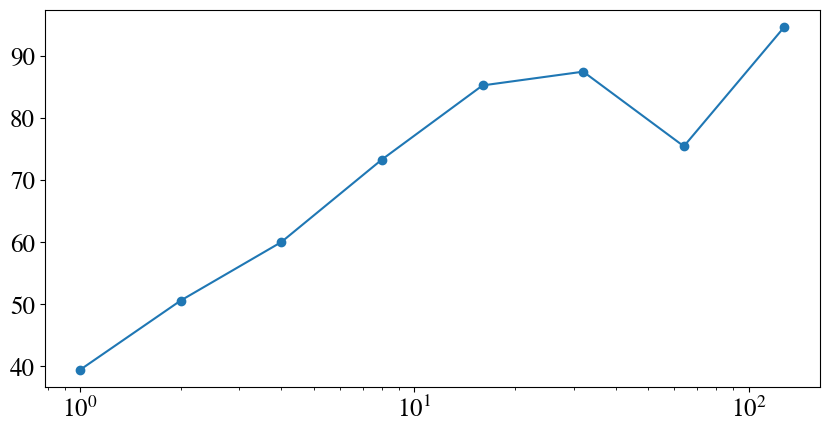

In [133]:
_key_fn = lambda f: int(f.stem.split("step")[1].split("_")[-1])
def _measure_fn(a, b):
    return np.mean(np.abs(a-b))

fils = list(MIDRES_ROOT.glob(f"{MODEL_NAME}_*"));
steps = np.array([_key_fn(f) for f in fils]);
fils = sorted(fils, key=_key_fn);

measures = []
for fil in fils:
    cur_res = load_pkl_folder2dict(fil, verbose=False)
    measures.append(np.mean([_measure_fn(a, b) for a, b in zip(cur_res.all_preds_dis, cur_res.all_trues_dis)]))
    
plt.plot(steps, measures, "-o")
plt.xscale("log")

<AxesSubplot:>

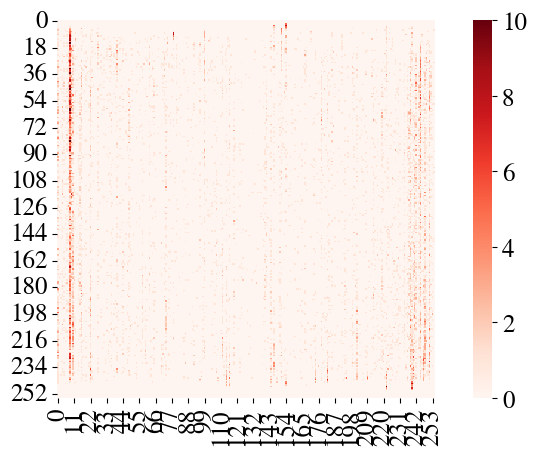

In [117]:
conf_mat = confusion_matrix(all_true_dis, all_pred_dis);
sns.heatmap(conf_mat, square=True, cmap="Reds", vmax=10)

## Code bak

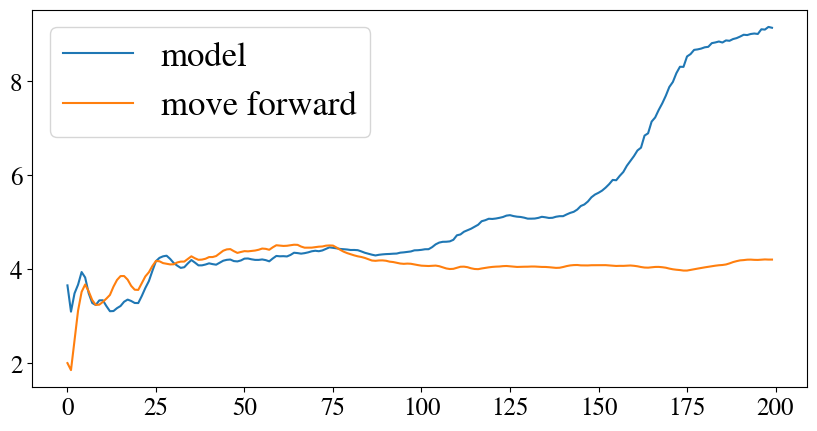

In [ ]:
len_seq = 100
loss_vs = []
for len_seq in range(1, pred_step+1):
    obs_data = full_seq[:, config.block_size:(config.block_size+len_seq)]
    move_f = torch.ones_like(obs_data) * full_seq[:, (config.block_size-1):config.block_size, :]
    pred_from_model = X_ext[:, config.block_size:(config.block_size+len_seq), :];
    loss_vs.append(
        (loss_fn(obs_data, pred_from_model).item(), 
        loss_fn(obs_data, move_f).item())
    )
loss_vs = np.array(loss_vs);
plt.plot(loss_vs[:, 0], label="model")
plt.plot(loss_vs[:, 1], label="move forward")
plt.legend()

# Compare multiple models

In [ ]:
model1 = "Lay2_dis_1step_correct_epoch1"
model2 = "Lay2_dis_1step_correct_epoch2"
model3 = "Lay2_dis_1step_epoch1"
model4 = "Lay2_dis_1step_epoch2"